In [3]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

In [4]:
def plotImage(image):
    plt.imshow(X=image, cmap="binary")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

def plotImageWithGrid(image):
    plt.imshow(X=image, cmap="binary")
    plt.tight_layout()
    plt.grid("on")
    plt.show()

In [27]:
def easy_case(data, empty_rows_threshold=10, empty_cols_threshold=10, scalling_coef_rows=0.04, scalling_coef_cols=0.04):
    """
    Checks if it is possible to separate the label with horizontal/vertical line,
    under the assumption is that the label is in the northwest part of the picture.
    :param data: 2-dimensional matrix
    :param empty_rows_threshold: rows with a sum of elements lower than that are find empty
    :param empty_cols_threshold: cols with a sum of elements lower than that are find empty
    :param scalling_coef_rows: proportion of half of the label to the whole picture
    :param scalling_coef_cols: proportion of half of the label to the whole picture
    :return: boolean value if algorithm worked
    """

    rowSums, colSums = data.sum(axis=1), data.sum(axis=0)

    emptyRows = (rowSums < empty_rows_threshold)
    firstNonEmptyRowIndex = np.argmax(emptyRows)
    if firstNonEmptyRowIndex < data.shape[0] // 2:
        labelSpaceHeight = np.argmax(emptyRows[firstNonEmptyRowIndex+int(data.shape[0]*scalling_coef_rows):])
        if labelSpaceHeight + firstNonEmptyRowIndex < data.shape[0] // 3:
            data[:labelSpaceHeight + firstNonEmptyRowIndex, :] = 0
            return True

    emptyCols = (colSums < empty_cols_threshold)
    firstNonEmptyColIndex = np.argmax(emptyCols)
    if firstNonEmptyColIndex < data.shape[1] // 2:
        labelSpaceWidth = np.argmax(emptyCols[firstNonEmptyColIndex+int(data.shape[0]*scalling_coef_cols):])
        if labelSpaceWidth + firstNonEmptyColIndex < data.shape[1] // 3:
            data[:, :labelSpaceWidth + firstNonEmptyColIndex] = 0
            print("kolumnowo")
            return True

    return False
            

def handle_labels_01(data):
    if easy_case(data):
        return data

    rowSums, colSums = data.sum(axis=1), data.sum(axis=0)
    
    rowDiffs = np.diff(rowSums)
    colDiffs = np.diff(colSums)

    rowDiffs = (rowDiffs < -40).astype(np.int32)
    colDiffs = (colDiffs < -50).astype(np.int32)

    rowDiffs = np.diff(rowDiffs)
    colDiffs = np.diff(colDiffs)

    data[:int(np.argmin(rowDiffs)*1.05), :int(np.argmin(colDiffs)*1.05)] = 0

    return data

def handle_labels_02(data, coeff = 0.4):
    if easy_case(data):
        return data
        
    rowSums, colSums = data.sum(axis=1), data.sum(axis=0)

    row = col = 0
    for i in range(1000):
        rowDiffs = np.diff(rowSums)
        colDiffs = np.diff(colSums)
    
        rowDiffs = (rowDiffs < -coeff*np.max(np.abs(rowDiffs))).astype(np.int32)
        colDiffs = (colDiffs < -coeff*np.max(np.abs(colDiffs))).astype(np.int32)
    
        rowDiffs = np.diff(rowDiffs)
        colDiffs = np.diff(colDiffs)
    
    data[:int(np.argmin(rowSums)*1.05), :int(np.argmin(colDiffs)*1.05)] = 0

    return data

def handle_labels_03(data, label_coeff=0.3, finalHeight = 1754, finalWidth = 1275):
    if easy_case(data):
        return data
    
    rowSums, colSums = data.sum(axis=1), data.sum(axis=0)
    
    for i in np.linspace(label_coeff, 0, 100):
        rowDiffs = np.diff(rowSums)
        colDiffs = np.diff(colSums)
    
        rowDiffs = (rowDiffs < -i*np.max(np.abs(rowDiffs[:data.shape[0]//2]))).astype(np.int8)
        colDiffs = (colDiffs < -i*np.max(np.abs(colDiffs[:data.shape[1]//2]))).astype(np.int8)

        rowDiffs = np.diff(rowDiffs)
        colDiffs = np.diff(colDiffs)

        if np.where(rowDiffs < 0)[0].shape[0] * np.where(colDiffs < 0)[0].shape[0] != 0:
            break
    else:
        print("Wystapił błąd")
        return data
        
    data[:int(np.where(rowDiffs)[0][-1]*1.05), :int(np.where(colDiffs)[0][-1]*1.05)] = 0
    return data

    #rowDiffs = (rowDiffs < -label_coeff*np.max(np.abs(rowDiffs[:data.shape[0]//2))).astype(np.int8)
    #colDiffs = (colDiffs < -label_coeff*np.max(np.abs(colDiffs[:data.shape[1]//2)).astype(np.int8)

    

    #rowDiffs[:350] = 0
    #colDiffs[:350] = 0

    

In [28]:
def pipeline(data, label_coeff = 0.3, reshape_coeff=5e-6, reshape_margin=0.5, 
             finalHeight = 1754, finalWidth = 1275):
    # handling label
    #data[:350, :350] = 0

    
    data = handle_labels_02(data)
    
    # reshaping
    rowSums, colSums = data.sum(axis=1), data.sum(axis=0)
    rowIndexes = colIndexes = np.array([])
    for i in range(1000):
        if rowIndexes.shape[0] * colIndexes.shape[0] != 0:
            break
        rows = rowSums >= reshape_coeff*np.max(rowSums)
        cols = colSums >= reshape_coeff*np.max(colSums)
        reshape_coeff *= 0.5
    
        colIndexes = np.where(cols)[0]
        rowIndexes = np.where(rows)[0]
    else:
        print(rowIndexes.shape, colIndexes.shape)
        print("Wystapił błąd")
        return np.zeros((finalHeight, finalWidth))

    rowFirst, rowLast = rowIndexes[1], rowIndexes[-1]
    colFirst, colLast = colIndexes[1], colIndexes[-1]
    rowWidth = rowLast - rowFirst
    colWidth = colLast - colFirst

    rowStart = max(int(rowFirst-reshape_margin*rowWidth), 0)
    colStart =  max(int(colFirst-reshape_margin*colWidth), 0)
    rowEnd = min(int(rowLast+reshape_margin*rowWidth), data.shape[0])
    colEnd = min(int(colLast+reshape_margin*colWidth), data.shape[1])
    
    data = data[rowStart:rowEnd, colStart:colEnd]

    paddingTop = max(0, (finalHeight - data.shape[0]) // 2)
    paddingBot = max(0, finalHeight - paddingTop - data.shape[0])
    paddingLeft = max(0, (finalWidth - data.shape[1]) // 2)
    paddingRight = max(0, finalWidth - paddingLeft - data.shape[1])

    data = np.pad(
        1 - data, # to save in proper colours 
        ((paddingTop, paddingBot), (paddingLeft, paddingRight)),
        mode="constant", constant_values=1
                 )
    
    return data

In [29]:
def read_and_convert_to_binary(filepath, threshold = 0.3, coef=0.4):
    """
    Requires numpy and Image from PIL
    """
    image = Image.open(filepath)

    data = np.asarray(image)
    data = 0.2989 * data[:,:,0] + 0.5870 * data[:,:,1] + 0.1140 * data[:,:,2]
    data = data / 255
    data = 1 - data

    rowSums = data.sum(axis=1)
    colSums = data.sum(axis=0)

    data[rowSums <= 4, :] = 0
    data[:, colSums <= 6] = 0
    
    data = data > threshold

    return data  

In [36]:
image = read_and_convert_to_binary("Skany profili//Profil 090.1.jpg")

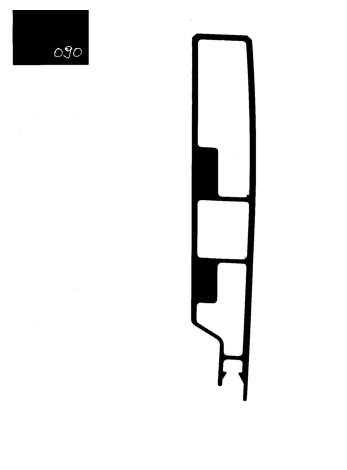

In [37]:
plotImage(image)

kolumnowo


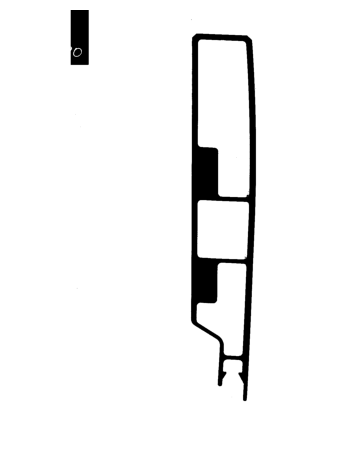

True


In [38]:
handled = easy_case(image)
plotImage(image)
print(handled)

In [17]:
for filename in os.listdir("Skany profili"):
    image = Image.fromarray((1-pipeline(read_and_convert_to_binary("Skany profili//"+filename)))*255).convert("1")
    image.save("without_labels_best//"+filename[:-4]+".png")